In [34]:
import pandas as pd
import numpy as np
import pyBigWig
from tqdm import tqdm
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot as gpp
gpp.set_aesthetics(context = 'paper')

In [35]:
figure3_outpath = '../../../Figures/Figure 3/'

In [36]:
#read in cleaned combined data
NewDatasetCombine = pd.read_csv('../../../Data/cleanedData/CombinedCleanedDatasets.csv', low_memory=False)

#get dataframe of unique guide/gene combinations across datasets
UniqueNewDatasetCombine = NewDatasetCombine[['Target Gene Symbol',
                                             'chromosome',
                                             'sgRNA Context Sequence',
                                             'sgRNA \'Cut\' Position']].drop_duplicates()

#alter chromosome notation to be compatible with bed files
UniqueNewDatasetCombine['chromosome'] = UniqueNewDatasetCombine['chromosome'].replace('chr24','chrY')
UniqueNewDatasetCombine['chromosome'] = UniqueNewDatasetCombine['chromosome'].replace('chr23','chrX')
UniqueNewDatasetCombine

,Target Gene Symbol,chromosome,sgRNA Context Sequence,sgRNA 'Cut' Position
0,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0
3,COQ2,chr4,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0
6,IGBP1,chrX,AATAAAAAAAAAAAGTGATCAGTTTGGAAA,70133000.0
9,YEATS4,chr12,AAAAAAAAAAAAAATTAACGTGCCAGGGGC,69360661.0
12,COPS3,chr17,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,17280422.0
...,...,...,...,...
257411,WDR11,chr10,GGCTAGGACCTCTACTACAATGAATGGGAG,120855890.0
257412,WDR11,chr10,GCTAGGACCTCTACTACAATGAATGGGAGA,120855891.0
257413,WDR11,chr10,CAGTCTTTCATCAAGTCTGATGTAAGGTAT,120855971.0
257414,WDR11,chr10,TTTATGTAGGTCCAAGTTTCAGTCTGGTAT,120856094.0


### Download histone ChIP-seq files

Download bigBed files containing pseudo replicated peaks derived from histone ChIP-seq data:

#### H3K4me3

- A549s: https://www.encodeproject.org/files/ENCFF595QEI/
- HCT116s: https://www.encodeproject.org/files/ENCFF021TMY/
- K562s: https://www.encodeproject.org/files/ENCFF898MJW/

#### H3k27ac

- A549s: https://www.encodeproject.org/files/ENCFF938XLV/
- HCT116s: https://www.encodeproject.org/files/ENCFF889BVY/
- K562s: https://www.encodeproject.org/files/ENCFF498JGL/

In [37]:
#read in ChIP bigBed files
file_path = '../../../Data/ChIP-seq/raw/'

#H3K4me3
H3K4me3_A549 = pyBigWig.open(file_path + 'ENCFF595QEI.bigBed')
H3K4me3_HCT116 = pyBigWig.open(file_path + 'ENCFF021TMY.bigBed')
H3K4me3_K562 = pyBigWig.open(file_path + 'ENCFF898MJW.bigBed')

#H3k27ac
H3k27ac_A549 = pyBigWig.open(file_path + 'ENCFF938XLV.bigBed')
H3k27ac_HCT116 = pyBigWig.open(file_path + 'ENCFF889BVY.bigBed')
H3k27ac_K562 = pyBigWig.open(file_path + 'ENCFF498JGL.bigBed')

In [38]:
def check_chromosome_in_bigbed(bigbed_file):
    sample_chr = ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 
                              'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 
                              'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 
                              'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 
                              'chr8', 'chr9', 'chrX', 'chrY']
    # Get a list of chromosomes in the BigBed file
    chromosomes = list(bigbed_file.chroms().keys())
    # Check if the specified chromosome exists in the BigBed file
    if set(chromosomes) == set(sample_chr):
        print(f"All Chromosomes exist in the BigBed file.")
    else:
        o2 = set(sample_chr) - set(chromosomes)
        print(f"Chromosome {o2} does not exist in the BigBed file.")

In [39]:
#check if all chromosomes are present in each bigBed
check_chromosome_in_bigbed(H3K4me3_A549)

All Chromosomes exist in the BigBed file.


In [40]:
check_chromosome_in_bigbed(H3K4me3_HCT116)

All Chromosomes exist in the BigBed file.


In [41]:
check_chromosome_in_bigbed(H3K4me3_K562)

All Chromosomes exist in the BigBed file.


In [42]:
check_chromosome_in_bigbed(H3k27ac_A549)

All Chromosomes exist in the BigBed file.


In [43]:
check_chromosome_in_bigbed(H3k27ac_HCT116)

Chromosome {'chrY'} does not exist in the BigBed file.


In [44]:
check_chromosome_in_bigbed(H3k27ac_K562)

Chromosome {'chrY'} does not exist in the BigBed file.


In [45]:
#create a version of the dataframe of guides that doesn't include the y chromosome
UniqueNewDatasetCombine_noY = UniqueNewDatasetCombine[UniqueNewDatasetCombine.chromosome != 'chrY'].copy()

### Compute Peak Overlap

In [46]:
def isInRange(n, tbl):
    #https://stackoverflow.com/questions/9019581/what-does-numpy-apply-along-axis-perform-exactly
    #https://stackoverflow.com/questions/71377816/check-if-value-is-between-two-values-in-numpy-array
    # n: is sgRNA location in the tiling/phenotypic dataset (need to subtract 1 because CRISPick is 1-based and bed files are 0-based)
    # tbl: numpy file of dataframe of bigbed with chro, start, and end of peak filtered_peak_file.to_numpy()
    #apply_along_axis applies the supplied function along 1D slices of the input array, 
    #with the slices taken along the axis you specify. 
    return sum(np.apply_along_axis(lambda row: row[0] <= n-1 < row[1], 1, tbl)\
        .tolist())

def peak_overlap(actual_tiling , bigbed_df, chrom, sgrna_location_col, chromosome_col = 'chromosome', 
                 gene_col = 'gene symbol'):
    # This function find whether guide overlaps with a peak in one chromosome 
    
    # actual_tiling: CRISPRi data (or any CRISPR data) with at least three columns 
    #                       [a location to indicate sgRNA, Gene name, Chromosome]
    #                       Note this DOES NOT require unique sgRNA location 
    # bigbed_df: ATAC seq from ENCODE in bigBed format and read through pyBigWig
    # chrom: string of chromosome such as 'chr1'
    # sgrna_location_col: string of column for sgRNA location
    
    # returns a dataframe, same as the actual_tilling but with an additional column overlap with peak to indicate 
    # whether theres an overlap between start and end of a peak and sgRNA location for one chromosome
    
    #----------------------------------------------------------------------------------------------------
    print(chrom)
    #subset chromsome number
    tiling_subset_chromo =  actual_tiling[actual_tiling[chromosome_col] == chrom].copy(deep=True)
    
    # select unique pam coord and chr and gene - remove duplicate 
    # tiling_lib: CRISPRi data (or any CRISPR data) with at least three columns 
    #                       [a location to indicate sgRNA, Gene name, Chromosome]
    #                       Note this should has unique sgRNA location 
    tiling_lib = tiling_subset_chromo.drop_duplicates(subset=[sgrna_location_col, chromosome_col,gene_col]).copy(deep=True)
    
    
    # change from string to int
    tiling_lib[sgrna_location_col] = list(map(int,tiling_lib[sgrna_location_col]))
    
    #obtain the smallest pam coord in a specific chromosome
    smallest_pam_coord = tiling_lib[sgrna_location_col].min()
    #obtain the largest pam coord in a specific chromosome
    largestest_pam_coord = tiling_lib[sgrna_location_col].max()

    
    #subset chrom number and having the end coord to be larger than the smallest pam coord
    
    # Retrieving bigBed entries in https://github.com/deeptools/pyBigWig explains
    # filtered_peak_file returns a list of tuple of (Start position in chromosome, End position in chromosome)
    filtered_peak_file = bigbed_df.entries(chrom, smallest_pam_coord, largestest_pam_coord, withString=False) 
    
    new_tiling_lib = tiling_lib.copy(deep=True)

    # make sure the selected peak file is not none
    if filtered_peak_file is not None:
    
        # only kept unique peaks and make it into dataframe because of https://www.biostars.org/p/464618/
        filtered_peak_file = pd.DataFrame(set(filtered_peak_file))


        # iterating over every single sgRNA location in the tiling library/a dataset with phenotypic data
        peak_list = [isInRange(x, filtered_peak_file.to_numpy()) 
                     for x in tqdm(np.nditer(tiling_lib[sgrna_location_col].to_numpy()), 
                                   total=len(tiling_lib[sgrna_location_col]),
                                   desc='number of unique sgRNA position and gene symbol for ' + chrom)]
    # if its None then return a list of 0 to show there is no overlaps
    else:
        peak_list = [0] *len(new_tiling_lib)

    
    #https://stackoverflow.com/questions/32573452/settingwithcopywarning-even-when-using-locrow-indexer-col-indexer-value
    new_tiling_lib.loc[:, 'overlap with peak'] = peak_list
    
    new_tiling_lib = new_tiling_lib[[gene_col, chromosome_col, sgrna_location_col, 'overlap with peak']]
    #b['overlap with peak'] = peak_list
    chr_df = pd.merge(actual_tiling, new_tiling_lib, on = [gene_col, chromosome_col, sgrna_location_col])

    return chr_df

def ATACseq_run(actual_tiling , bigbed_df, sgrna_location_col, chromosome_col = 'chromosome', gene_col = 'gene symbol'):
    anno_peak = pd.DataFrame()
    
    # This function iterate over all the chromosome to run the function [peak_overlap] and concatenate them together
    # actual_tiling: CRISPRi data (or any CRISPR data) with at least three columns 
    #                       [a location to indicate sgRNA, Gene name, Chromosome]
    #                       Note this DOES NOT require unique sgRNA location 
    # bigbed_df: ATAC seq from ENCODE in bigBed format and read through pyBigWig
    # sgrna_location_col: string of column name for sgRNA location
    # chromosome_col: string of column name for chromosome
    # gene_col: string of column name for 'gene symbol'
    
    # returns a dataframe, same as the actual_tilling but with an additional column overlap with peak to indicate 
    # whether theres an overlap between start and end of a peak and sgRNA location for mutiple chromosomes
    
    # a list of chromosome in the data
    chromo_list = set(actual_tiling[chromosome_col])
    print('There are total', len(chromo_list), 
      ' chromosome in the dataset and they are ',set(chromo_list)) 
    
    #iterate peak_overlap function for all the chromosome
    for chromo in chromo_list:
        print(chromo)
        chrom_num_df = peak_overlap(actual_tiling = actual_tiling, bigbed_df = bigbed_df, chrom = chromo, 
                                    sgrna_location_col = sgrna_location_col, 
                                    chromosome_col = chromosome_col, gene_col = gene_col)
        anno_peak = pd.concat([anno_peak, chrom_num_df])
        
    return anno_peak

In [47]:
#compute peak overlap in each cell line

#H3K4me3

# chrtest_H3K4me3_A549 = ATACseq_run(actual_tiling= UniqueNewDatasetCombine, bigbed_df = H3K4me3_A549, 
#                                      sgrna_location_col = 'sgRNA \'Cut\' Position', chromosome_col = 'chromosome', gene_col = 'Target Gene Symbol' )

# chrtest_H3K4me3_HCT116 = ATACseq_run(actual_tiling= UniqueNewDatasetCombine, bigbed_df = H3K4me3_HCT116, 
#                                      sgrna_location_col = 'sgRNA \'Cut\' Position', chromosome_col = 'chromosome', gene_col = 'Target Gene Symbol' )

# chrtest_H3K4me3_K562 = ATACseq_run(actual_tiling= UniqueNewDatasetCombine, bigbed_df = H3K4me3_K562, 
#                                      sgrna_location_col = 'sgRNA \'Cut\' Position', chromosome_col = 'chromosome', gene_col = 'Target Gene Symbol' )

# #H3k27ac

# chrtest_H3k27ac_A549 = ATACseq_run(actual_tiling= UniqueNewDatasetCombine, bigbed_df = H3k27ac_A549, 
#                                      sgrna_location_col = 'sgRNA \'Cut\' Position', chromosome_col = 'chromosome', gene_col = 'Target Gene Symbol' )

# chrtest_H3k27ac_HCT116 = ATACseq_run(actual_tiling= UniqueNewDatasetCombine_noY, bigbed_df = H3k27ac_HCT116, 
#                                      sgrna_location_col = 'sgRNA \'Cut\' Position', chromosome_col = 'chromosome', gene_col = 'Target Gene Symbol' )

# chrtest_H3k27ac_K562 = ATACseq_run(actual_tiling= UniqueNewDatasetCombine_noY, bigbed_df = H3k27ac_K562, 
#                                      sgrna_location_col = 'sgRNA \'Cut\' Position', chromosome_col = 'chromosome', gene_col = 'Target Gene Symbol' )

In [48]:
# chrtest_H3K4me3_A549.to_csv('../../../Data/ChIP-seq/H3K4me3_A549.csv', index = False)
# chrtest_H3K4me3_HCT116.to_csv('../../../Data/ChIP-seq/H3K4me3_HCT116.csv', index = False)
# chrtest_H3K4me3_K562.to_csv('../../../Data/ChIP-seq/H3K4me3_K562.csv', index = False)
# chrtest_H3k27ac_A549.to_csv('../../../Data/ChIP-seq/H3k27ac_A549.csv', index = False)
# chrtest_H3k27ac_HCT116.to_csv('../../../Data/ChIP-seq/H3k27ac_HCT116.csv', index = False)
# chrtest_H3k27ac_K562.to_csv('../../../Data/ChIP-seq/H3k27ac_K562.csv', index = False)

In [49]:
chrtest_H3K4me3_A549 = pd.read_csv('../../../Data/ChIP-seq/H3K4me3_A549.csv')
chrtest_H3K4me3_HCT116 = pd.read_csv('../../../Data/ChIP-seq/H3K4me3_HCT116.csv')
chrtest_H3K4me3_K562 = pd.read_csv('../../../Data/ChIP-seq/H3K4me3_K562.csv')
chrtest_H3k27ac_A549 = pd.read_csv('../../../Data/ChIP-seq/H3k27ac_A549.csv')
chrtest_H3k27ac_HCT116 = pd.read_csv('../../../Data/ChIP-seq/H3k27ac_HCT116.csv')
chrtest_H3k27ac_K562 = pd.read_csv('../../../Data/ChIP-seq/H3k27ac_K562.csv')

In [50]:
chrtest_H3K4me3_A549['ChIPseq'] = 'H3K4me3_A549'
chrtest_H3K4me3_HCT116['ChIPseq'] = 'H3K4me3_HCT116'
chrtest_H3K4me3_K562['ChIPseq'] = 'H3K4me3_K562'
chrtest_H3k27ac_A549['ChIPseq'] = 'H3k27ac_A549'
chrtest_H3k27ac_HCT116['ChIPseq'] = 'H3k27ac_HCT116'
chrtest_H3k27ac_K562['ChIPseq'] = 'H3k27ac_K562'

In [51]:
chrtest = pd.concat([chrtest_H3K4me3_A549,chrtest_H3K4me3_HCT116,chrtest_H3K4me3_K562,
                     chrtest_H3k27ac_A549,chrtest_H3k27ac_HCT116,chrtest_H3k27ac_K562])
chrtest

,Target Gene Symbol,chromosome,sgRNA Context Sequence,sgRNA 'Cut' Position,overlap with peak,ChIPseq
0,ATXN10,chr22,AATAAAAGACAGTTCCAAACCTGAAGGAAC,45670851.0,0,H3K4me3_A549
1,ATXN10,chr22,GGAATCAGACAAGGCTTCTCTAGCTGGTGT,45670985.0,0,H3K4me3_A549
2,ATXN10,chr22,AATATATTTCACAGGAATCAGACAAGGCTT,45670998.0,0,H3K4me3_A549
3,ATXN10,chr22,AAGAAGCTAAGTTACACAGCAATAGGGTTA,45671055.0,0,H3K4me3_A549
4,ATXN10,chr22,CTGATCAATACCAGACCACTTACCAGGCAC,45671147.0,1,H3K4me3_A549
...,...,...,...,...,...,...
122024,TRRAP,chr7,ACTCAGAGAAAGAGAAAATACCGTAGGAAG,98880869.0,0,H3k27ac_K562
122025,TRRAP,chr7,AGAGAAAGAGAAAATACCGTAGGAAGGAAC,98880873.0,0,H3k27ac_K562
122026,TRRAP,chr7,AAACTTCATATTAAAAAAACCAGAAGGAAT,98880959.0,0,H3k27ac_K562
122027,TRRAP,chr7,AAGATGAAAGCGTATCGATTATGTAGGCCT,98881007.0,0,H3k27ac_K562


In [52]:
ChIP_combined = NewDatasetCombine.merge(chrtest, on = ['Target Gene Symbol','chromosome','sgRNA Context Sequence','sgRNA \'Cut\' Position'],
                                        how = 'inner')
ChIP_combined

,Target Gene Symbol,chromosome,sgRNA Sequence,sgRNA Context Sequence,sgRNA 'Cut' Position,Strand of Target,Strand of sgRNA,TSS Position,sgRNA 'Cut' Site TSS Offset,Phenotype scores-ave_Rep1_Rep2,...,DataSet,zscoreRelativeNC_signed,Avg_LFC_signed,z_scored_avg_lfc,rs3ChenSeqScore,cellDomainDataSet,z_score,signed_zscore,overlap with peak,ChIPseq
0,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.398339,0.013999,A549_Kox1_InHouse,-0.398339,0.398339,1,H3K4me3_A549
1,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.398339,0.013999,A549_Kox1_InHouse,-0.398339,0.398339,1,H3K4me3_HCT116
2,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.398339,0.013999,A549_Kox1_InHouse,-0.398339,0.398339,1,H3K4me3_K562
3,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.398339,0.013999,A549_Kox1_InHouse,-0.398339,0.398339,1,H3k27ac_A549
4,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.398339,0.013999,A549_Kox1_InHouse,-0.398339,0.398339,1,H3k27ac_HCT116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527151,WDR11,chr10,gttcttaaagtgcctgtctaatat,GTTCTTAAAGTGCCTGTCTAATATTGGTTG,120856156.0,+,+,120851363.0,4793.0,NaN,...,Gilbert,-0.08892,0.190405,NaN,-0.041807,K562_Kox1_Gilbert,-0.088920,-0.088920,0,H3K4me3_HCT116
1527152,WDR11,chr10,gttcttaaagtgcctgtctaatat,GTTCTTAAAGTGCCTGTCTAATATTGGTTG,120856156.0,+,+,120851363.0,4793.0,NaN,...,Gilbert,-0.08892,0.190405,NaN,-0.041807,K562_Kox1_Gilbert,-0.088920,-0.088920,0,H3K4me3_K562
1527153,WDR11,chr10,gttcttaaagtgcctgtctaatat,GTTCTTAAAGTGCCTGTCTAATATTGGTTG,120856156.0,+,+,120851363.0,4793.0,NaN,...,Gilbert,-0.08892,0.190405,NaN,-0.041807,K562_Kox1_Gilbert,-0.088920,-0.088920,0,H3k27ac_A549
1527154,WDR11,chr10,gttcttaaagtgcctgtctaatat,GTTCTTAAAGTGCCTGTCTAATATTGGTTG,120856156.0,+,+,120851363.0,4793.0,NaN,...,Gilbert,-0.08892,0.190405,NaN,-0.041807,K562_Kox1_Gilbert,-0.088920,-0.088920,0,H3k27ac_HCT116


In [53]:
ChIP_combined.groupby(['cellDomainDataSet','sgRNA Context Sequence'])['ChIPseq'].count().value_counts()

6    254526
Name: ChIPseq, dtype: int64

In [54]:
ChIP_combined['overlap with peak'].value_counts()

1    1303169
0     223987
Name: overlap with peak, dtype: int64

In [55]:
ChIP_combined.to_csv('../../../Data/ChIP-seq/combinedDatasetsChIPseqOverlap.csv',index=False)

### Perform within-gene Mann Whitney U tests

In [26]:
def perform_mannwhitney_tests(chrtest, gene_col, phenotype):
    results = []
    # Get unique values from the specified columns
    ChIPseq = chrtest['ChIPseq'].unique()
    DataSet = chrtest['DataSet'].unique()
    Domain = chrtest['Domain'].unique()
    condition = chrtest['condition'].unique()

    # Iterate over the combinations of parameters
    for chip in tqdm(ChIPseq):
        
        for data in tqdm(DataSet):
            alter = 'less'
            for krab in tqdm(Domain):
                for cell in tqdm(condition):
                    chrtest_subset = chrtest[(chrtest['ChIPseq'] == chip) & (chrtest['Domain'] == krab) & 
                                             (chrtest['DataSet'] == data) & (chrtest['condition'] == cell)]
                    for gene in chrtest_subset[gene_col].unique():
                        gene_sp = chrtest_subset[chrtest_subset[gene_col] == gene]
                        binary_col = 'overlap with peak'
                        if (sum(gene_sp[binary_col] == 1) >= 10) & (sum(gene_sp[binary_col] == 0) >= 10):
                            _, pval = mannwhitneyu(gene_sp[gene_sp[binary_col] == 0][phenotype], 
                                                   gene_sp[gene_sp[binary_col] == 1][phenotype], 
                                                   alternative=alter, method="asymptotic")
                            results.append({
                                'ChIPseq': chip,
                                'DataSet': data,
                                'Domain': krab,
                                'condition': cell,
                                'gene': gene,
                                'pval': pval
                            })
                        else:
                            print(f"{gene}: Sample size in overlap or non-overlap < 10")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [27]:
results_df = perform_mannwhitney_tests(ChIP_combined, 'Target Gene Symbol', 'signed_zscore')
results_df['DataSetID'] = results_df[['DataSet', 'Domain', 'condition']].agg("_".join, axis=1)
results_df

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

POP5: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
SPCS3: Sample size in overlap or non-overlap < 10




 33%|███████████████                              | 1/3 [00:00<00:01,  1.36it/s]

SLC25A28: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
POP5: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap <




 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.73it/s]

PRMT5: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.37s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

POP5: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
SPCS3: Sample size in overlap or non-overlap < 10




 33%|███████████████                              | 1/3 [00:00<00:00,  2.24it/s]

SLC25A28: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overla




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.24it/s]

DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.45s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.90it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.95it/s]

POP5: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
NUP160: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
COG3: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10
PSMD4: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
MRPS25: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
ANAPC13: Sample size in overlap or non-overlap < 1




100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.34s/it]

RPS6: Sample size in overlap or non-overlap < 10
RRM1: Sample size in overlap or non-overlap < 10
RSL24D1: Sample size in overlap or non-overlap < 10
SAMM50: Sample size in overlap or non-overlap < 10
SCFD1: Sample size in overlap or non-overlap < 10
SF3B2: Sample size in overlap or non-overlap < 10
SF3B4: Sample size in overlap or non-overlap < 10
SIRT7: Sample size in overlap or non-overlap < 10
SLC35A1: Sample size in overlap or non-overlap < 10
SMC2: Sample size in overlap or non-overlap < 10
SNRNP200: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10
SPC24: Sample size in overlap or non-overlap < 10
SPDL1: Sample size in overlap or non-overlap < 10
SRFBP1: Sample size in overlap or non-overlap < 10
SRRT: Sample size in overlap or non-overlap < 10
SSBP1: Sample size in overlap or non-overlap < 10
SUPV3L1: Sample size in overlap or non-overlap < 10
TEX10: Sample size in overlap or non-overl




  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.74it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.76it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.78it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

 67%|██████████████████████████████               | 2/3 [00:04<00:02,  2.11s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.69it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.74it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.62it/s]


  0

POP5: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
ARGLU1: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 




 33%|███████████████                              | 1/3 [00:00<00:00,  2.21it/s]

PRMT5: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
SKA1: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
POP5: Sample size in overlap or non-overlap < 10
D




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.24it/s]

ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
SKA1: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.06s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

POP5: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
ARGLU1: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
NUP160: Sample size in overlap or non-overlap <




 33%|███████████████                              | 1/3 [00:00<00:00,  2.26it/s]

DDOST: Sample size in overlap or non-overlap < 10
SKA1: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 1




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.26it/s]

DDOST: Sample size in overlap or non-overlap < 10
SKA1: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.12s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.02it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.07it/s]

POP5: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
NUP160: Sample size in overlap or non-overlap < 10
UMPS: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
COG3: Sample size in overlap or non-overlap < 10
TTK: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
HINFP: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
ANAPC13: Sample size in overlap or non-overlap < 10
AT




100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.31s/it]

SUPV3L1: Sample size in overlap or non-overlap < 10
SURF6: Sample size in overlap or non-overlap < 10
TEX10: Sample size in overlap or non-overlap < 10
THG1L: Sample size in overlap or non-overlap < 10
TICRR: Sample size in overlap or non-overlap < 10
TPX2: Sample size in overlap or non-overlap < 10
TRMT10C: Sample size in overlap or non-overlap < 10
TSEN2: Sample size in overlap or non-overlap < 10
UQCRFS1: Sample size in overlap or non-overlap < 10
UTP3: Sample size in overlap or non-overlap < 10
VPS72: Sample size in overlap or non-overlap < 10
WDR75: Sample size in overlap or non-overlap < 10
XRCC5: Sample size in overlap or non-overlap < 10
ZCCHC9: Sample size in overlap or non-overlap < 10
ZNF574: Sample size in overlap or non-overlap < 10
ZNF830: Sample size in overlap or non-overlap < 10
ZNHIT6: Sample size in overlap or non-overlap < 10





  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.91it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.97it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.94it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it/s]

 67%|██████████████████████████████               | 2/3 [00:03<00:01,  1.95s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.94it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.96it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.25it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.75it/s]


  0

DHX15: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
NRBP1: Sample size in overlap or non-overlap < 10
DDB




 33%|███████████████                              | 1/3 [00:00<00:00,  2.11it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 1




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.15it/s]

PRMT5: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.10s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

DHX15: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
NRBP1: Sample size in overlap or non-overlap < 10
DDB




 33%|███████████████                              | 1/3 [00:00<00:00,  2.20it/s]

SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10





 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.17it/s]

MRPS23: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.23s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.98it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.93it/s]

DHX15: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
NUP160: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
MRPS25: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
ANAPC13: Sample size in overlap or non-overlap < 10
ATP6V1C1: Sample size in overlap or non-overlap < 10
ATR: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 




100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.36s/it]

RSL24D1: Sample size in overlap or non-overlap < 10
SAMM50: Sample size in overlap or non-overlap < 10
SART1: Sample size in overlap or non-overlap < 10
SCFD1: Sample size in overlap or non-overlap < 10
SF3B4: Sample size in overlap or non-overlap < 10
SLC35A1: Sample size in overlap or non-overlap < 10
SMC2: Sample size in overlap or non-overlap < 10
SMNDC1: Sample size in overlap or non-overlap < 10
SNRNP200: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SPDL1: Sample size in overlap or non-overlap < 10
SRFBP1: Sample size in overlap or non-overlap < 10
SRRT: Sample size in overlap or non-overlap < 10
SSBP1: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10
SUPV3L1: Sample size in overlap or non-overlap < 10
SURF6: Sample size in overlap or non-overlap < 10
TEX10: Sample size in overlap or non-overlap < 10
TPX2: Sample size in overlap or non-overlap < 10
TRMT10C: Sample size in overlap or non




  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.79it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.85it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.83it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

 67%|██████████████████████████████               | 2/3 [00:04<00:02,  2.02s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.84it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.87it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.21it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.73it/s]


  0

COQ2: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
ELP6: Sample size in overlap or non-overlap < 10
MARS1: Sample size in overlap or non-overlap < 10
GMPPB: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
RNF168: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
METTL17: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap




 33%|███████████████                              | 1/3 [00:00<00:00,  2.11it/s]

WEE1: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
COQ2: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.18it/s]

WEE1: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.09s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

COQ2: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
ELP6: Sample size in overlap or non-overlap < 10
MARS1: Sample size in overlap or non-overlap < 10
GMPPB: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
RNF168: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap <




 33%|███████████████                              | 1/3 [00:00<00:00,  2.23it/s]

WEE1: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.25it/s]

PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.16s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.65it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.63it/s]

DHX15: Sample size in overlap or non-overlap < 10
AURKB: Sample size in overlap or non-overlap < 10
METTL17: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
NUP160: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1E: Sample size in overlap or non-overlap < 10
MTPAP: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
COG3: Sample size in overlap or non-overlap < 10
FBL: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10
PSMD4: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10




100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.36s/it]

TEX10: Sample size in overlap or non-overlap < 10
TIMELESS: Sample size in overlap or non-overlap < 10
TPX2: Sample size in overlap or non-overlap < 10
TSEN2: Sample size in overlap or non-overlap < 10
UQCRB: Sample size in overlap or non-overlap < 10
UQCRFS1: Sample size in overlap or non-overlap < 10
UTP3: Sample size in overlap or non-overlap < 10
VPS54: Sample size in overlap or non-overlap < 10
VPS72: Sample size in overlap or non-overlap < 10
WDR75: Sample size in overlap or non-overlap < 10
XRCC5: Sample size in overlap or non-overlap < 10
ZCCHC9: Sample size in overlap or non-overlap < 10
ZNF830: Sample size in overlap or non-overlap < 10
ZNHIT6: Sample size in overlap or non-overlap < 10





  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.72it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.79it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.78it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

 67%|██████████████████████████████               | 2/3 [00:04<00:02,  2.00s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.80it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.81it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.13it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.71it/s]


  0

YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
PUF60: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap




 33%|███████████████                              | 1/3 [00:00<00:00,  2.04it/s]

TAF10: Sample size in overlap or non-overlap < 10
DICER1: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overla




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.06it/s]

DICER1: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.14s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
PUF60: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap




 33%|███████████████                              | 1/3 [00:00<00:00,  2.10it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overl




 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.05it/s]

TAF10: Sample size in overlap or non-overlap < 10
DICER1: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.29s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.88it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.93it/s]

DHX15: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
TOP2A: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
ANAPC13: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CCT3: Sample size in overlap or non-overlap < 10
CENPM: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CHEK1: Sample size in overlap or non-overlap < 10
CHMP2A: Sample size in overlap or non-overlap < 10
CLSPN: Sample size in overlap or non-overlap < 1




100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.43s/it]

UTP3: Sample size in overlap or non-overlap < 10
VPS54: Sample size in overlap or non-overlap < 10
VPS72: Sample size in overlap or non-overlap < 10
ZNF574: Sample size in overlap or non-overlap < 10





  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.83it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.82it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.87it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

 67%|██████████████████████████████               | 2/3 [00:04<00:02,  2.09s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.72it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.77it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.13it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.71it/s]


  0

COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
PUF60: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 1




 33%|███████████████                              | 1/3 [00:00<00:01,  1.71it/s]

NRBP1: Sample size in overlap or non-overlap < 10
PPP1R8: Sample size in overlap or non-overlap < 10
DDB1: Sample size in overlap or non-overlap < 10
RPN2: Sample size in overlap or non-overlap < 10
TNPO3: Sample size in overlap or non-overlap < 10
RRM2: Sample size in overlap or non-overlap < 10
MRPS25: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
UPF2: Sample size in overlap or non-overlap < 10
ATP5F1B: Sample size in overlap or non-overlap < 10
LUC7L3: Sample size in overlap or non-overlap < 10
IARS1: Sample size in overlap or non-overlap < 10
SOD1: Sample size in overlap or non-overlap < 10
DAP3: Sample size in overlap or non-overlap < 10
TAF10: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 




 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.97it/s]

MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.21s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
PUF60: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 1




 33%|███████████████                              | 1/3 [00:00<00:00,  2.14it/s]

MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap




 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.87it/s]

MRPS25: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
UPF2: Sample size in overlap or non-overlap < 10
ATP5F1B: Sample size in overlap or non-overlap < 10
LUC7L3: Sample size in overlap or non-overlap < 10
IARS1: Sample size in overlap or non-overlap < 10
SOD1: Sample size in overlap or non-overlap < 10
DAP3: Sample size in overlap or non-overlap < 10
TAF10: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 




100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.44s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.91it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.76it/s]

DHX15: Sample size in overlap or non-overlap < 10
AURKB: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
NUP160: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
COG3: Sample size in overlap or non-overlap < 10
FBL: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
RRM2: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
MRPS25: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
ANAPC13: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CH




100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.43s/it]

UTP3: Sample size in overlap or non-overlap < 10
VPS54: Sample size in overlap or non-overlap < 10
VPS72: Sample size in overlap or non-overlap < 10
WDR75: Sample size in overlap or non-overlap < 10
ZCCHC9: Sample size in overlap or non-overlap < 10
ZNHIT6: Sample size in overlap or non-overlap < 10





  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.87it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.88it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.88it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

 67%|██████████████████████████████               | 2/3 [00:04<00:02,  2.15s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.84it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.90it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.25it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.75it/s]


  0

,ChIPseq,DataSet,Domain,condition,gene,pval,DataSetID
0,H3K4me3_A549,InHouse,Kox1,A549,LARS2,2.162801e-03,InHouse_Kox1_A549
1,H3K4me3_A549,InHouse,Kox1,A549,COQ2,7.380949e-01,InHouse_Kox1_A549
2,H3K4me3_A549,InHouse,Kox1,A549,YEATS4,3.694306e-02,InHouse_Kox1_A549
3,H3K4me3_A549,InHouse,Kox1,A549,COPS3,1.312066e-02,InHouse_Kox1_A549
4,H3K4me3_A549,InHouse,Kox1,A549,RPAP1,1.201272e-12,InHouse_Kox1_A549
...,...,...,...,...,...,...,...
3291,H3k27ac_K562,Gilbert,Kox1,K562,TRAPPC8,1.227049e-09,Gilbert_Kox1_K562
3292,H3k27ac_K562,Gilbert,Kox1,K562,TUBA1B,4.709910e-01,Gilbert_Kox1_K562
3293,H3k27ac_K562,Gilbert,Kox1,K562,UGP2,7.438061e-09,Gilbert_Kox1_K562
3294,H3k27ac_K562,Gilbert,Kox1,K562,VPS53,2.362844e-04,Gilbert_Kox1_K562


### Plot results

In [28]:
def categorize_pval(df, col= '-log10(pval)'):
    new_df = df.copy()
    conditions  = [ new_df[col] < 1, 
                   (new_df[col] >= 1) & (new_df[col]< 2), 
                   (new_df[col] >= 2) & (new_df[col]< 3), 
                   (new_df[col] >= 3) & (new_df[col]< 4),
                  new_df[col] >= 4]
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    new_df["-log10(pval) bins"] = np.select(conditions, choices, default=np.nan)
    return new_df

In [31]:
allDataCount = pd.DataFrame()
for dataset in results_df.DataSetID.unique():
    select_pval = results_df[results_df.DataSetID == dataset].copy()
    select_pval['-log10(pval)'] = -np.log10(select_pval['pval'])
    select_pval = categorize_pval(select_pval)
    select_count = pd.DataFrame(select_pval.groupby(['-log10(pval) bins', 'ChIPseq']).size().reset_index(name='counts'))
    select_count['DataSetID'] = dataset
    allDataCount = pd.concat([allDataCount, select_count])
    allDataCount[['Histone Marker', 'Cell Line']] = allDataCount['ChIPseq'].str.split('_', expand=True)

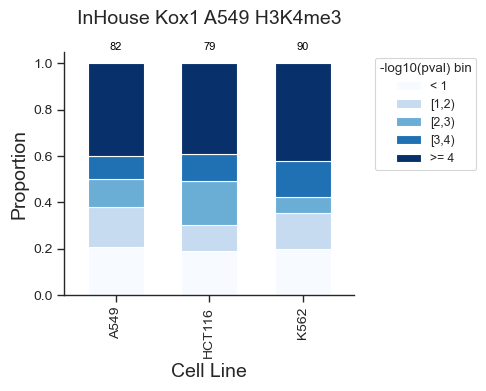

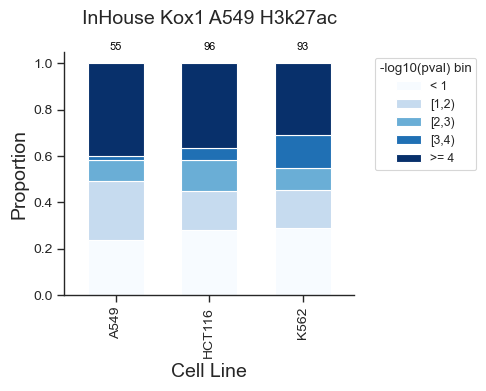

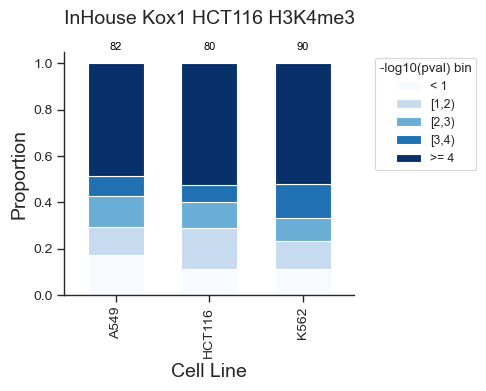

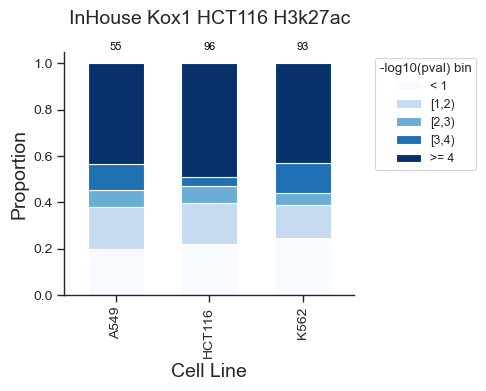

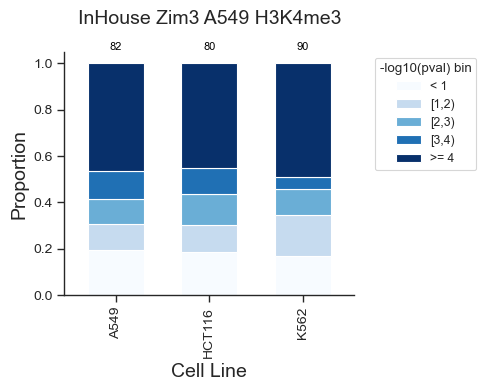

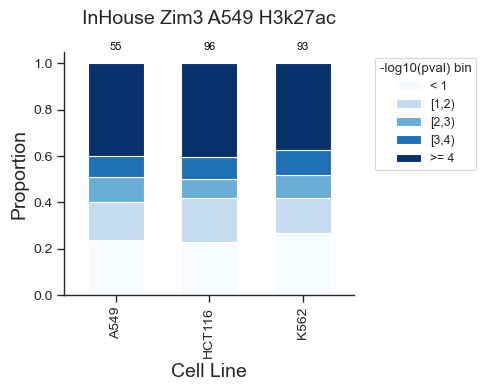

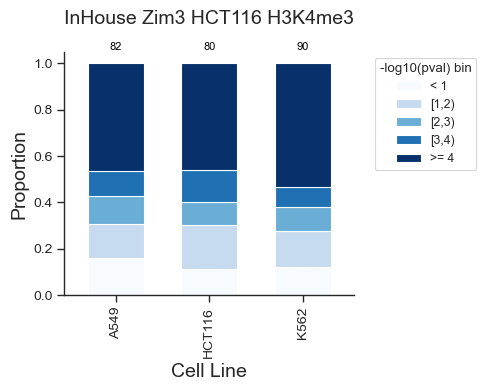

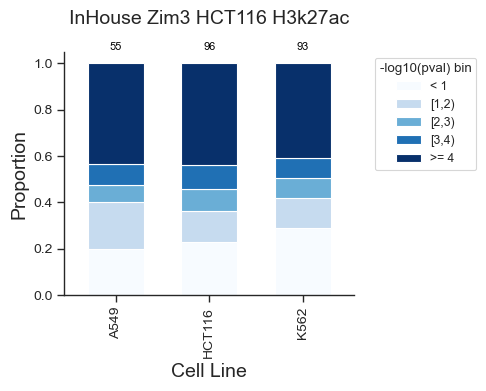

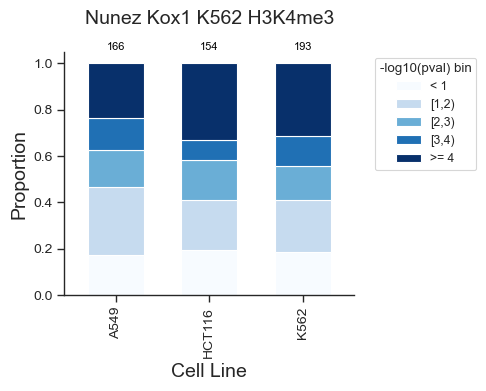

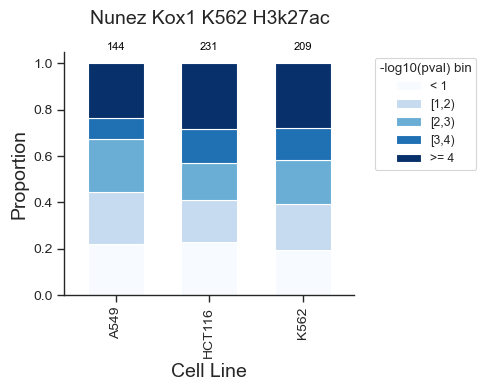

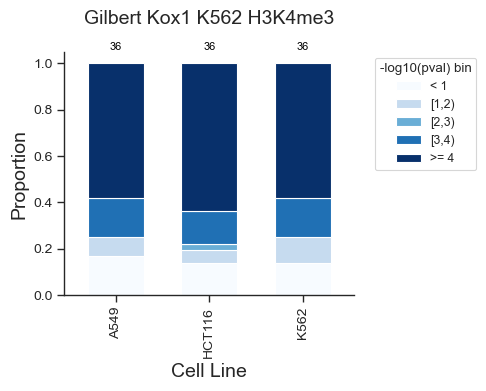

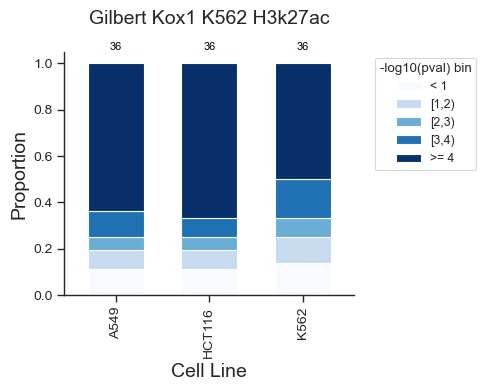

In [33]:
required_columns = ['A549','HCT116','K562']
dataset = allDataCount.DataSetID.unique()
for selectData in dataset:
    selectData_df = allDataCount[allDataCount['DataSetID'] == selectData].copy()

    for selectHistone in ['H3K4me3', 'H3k27ac']:
        select_count = selectData_df[selectData_df['Histone Marker'] == selectHistone].copy()

        grouped_df = select_count.groupby(['-log10(pval) bins', 'Cell Line'])['counts'].sum().unstack().fillna(0)
        # # Add missing required columns with zeros
        # for col in required_columns:
        #     if (col not in grouped_df.columns):
        #         grouped_df[col] = 0


        # Calculate percentages
        grouped_df_percentage = grouped_df.transpose().divide(grouped_df.sum(axis=0), axis=0)
        grouped_df_percentage = grouped_df_percentage[['< 1','[1,2)', '[2,3)','[3,4)','>= 4']]

        # Change the index format
        grouped_df_percentage.index = grouped_df_percentage.index.str.replace('_', ' ')
        # Plotting
        fig, ax = plt.subplots(figsize=(5, 4))

        grouped_df_percentage.plot(kind='bar', stacked=True, ax=ax, width=0.6, cmap = 'Blues')

        # Add percentages to the bars and the total count
        for i in range(grouped_df_percentage.shape[0]):
            total = 0
            totalCount = grouped_df.iloc[:, i].sum()  # Calculate the total count for each stack
            # Add total count text on top of each stack
            ax.text(i, 1.05, f'{int(totalCount)}', ha='center', va='bottom', fontsize=8, fontweight='light', color='black')

        plt.ylabel('Proportion', fontsize=14, fontfamily='Arial')
        plt.xlabel('Cell Line', fontsize=14, fontfamily='Arial')
        plt.title(selectData.replace('_',' ') + ' ' + selectHistone, pad=20, fontsize=14, fontfamily='Arial')
        ax.tick_params(axis='both', labelsize=10)
        plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
        sns.despine()
        plt.tight_layout()
        gpp.savefig(figure3_outpath + selectData + "_" + selectHistone + "_stacked_barplot.pdf", dpi=300, bbox_inches='tight')
        plt.show()